<b>Donoho-Johnstone Benchmarks for Neural Nets</b>

Warren S. Sarle, SAS Institute Inc., Cary, NC, USA
ftp://ftp.sas.com/pub/neural/dojo/dojo.html

<i>"The benchmark data sets used by neural net and machine learning researchers tend to have many inputs, either no noise or lots of noise, and little to moderate nonlinearity. A very different set of benchmarks has become popular in the statistical literature based on several articles by Donoho and Johnstone (1994; 1995; Donoho, Johnstone, Kerkyacharian, and Picard 1995)...",</i>

<b>Further Reading</b>
<p>
ftp://ftp.sas.com/pub/neural/dojo/dojo.html
<p>
https://www.mathworks.com/help/wavelet/ref/wnoise.html

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex

import numpy as np
import math, random
import pandas as pd

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn.init as init
import torch.utils.data
import torch.optim 
from torch.optim import lr_scheduler

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

from makesig import *
from utils import *

In [2]:
%load_ext watermark
%watermark -a "tb" -d -v -m -p sys,numpy,pandas,sklearn,torch,IPython
gpu_stat()

tb 2018-08-31 

CPython 3.6.4
IPython 6.2.1

sys 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy 1.14.2
pandas 0.22.0
sklearn 0.19.1
torch 0.4.0a0+9692519
IPython 6.2.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.5.0
machine    : x86_64
processor  : i386
CPU cores  : 24
interpreter: 64bit

GPU Name: TITAN Xp
GPU Memory: 12.0GB
CUDA Version: (9, 1, 0)
GPU Free/Total Memory: 90%


In [3]:
# Hyperparameters
HP = HYPERPARAMETERS({
    "GPU"                 : True ,
    'NUM_HIDDEN_NODES'    : 50 ,
    'NUM_EXAMPLES'        : 10000 ,
    "SNR"                 : 700.0,
    'TRAIN_SPLIT'         : .8 ,
    'MINI_BATCH_SIZE'     : 200 ,
    'NUM_EPOCHS'          : 300 ,
    'LEARNING_RATE'       : 5e-3 ,
    'LEARNING_RATE_DECAY' : 30 ,
    'WEIGHT_DECAY'        : 5e-4 ,
    'NUM_MOMENTUM'        : 0.9 ,
    'NUM_PATIENCE'        : 50 ,
    'SIGNAL'              : 'Cusp',
    "SNR"                 : 30,
    "SEED"                : 2018
})

In [4]:
if not HP.GPU:
    torch.cuda.is_available = lambda : False

In [5]:
# Seed random generators for repro 
np.random.seed(HP.SEED)  
torch.manual_seed(HP.SEED);
if torch.cuda.is_available():
    torch.cuda.manual_seed(HP.SEED)

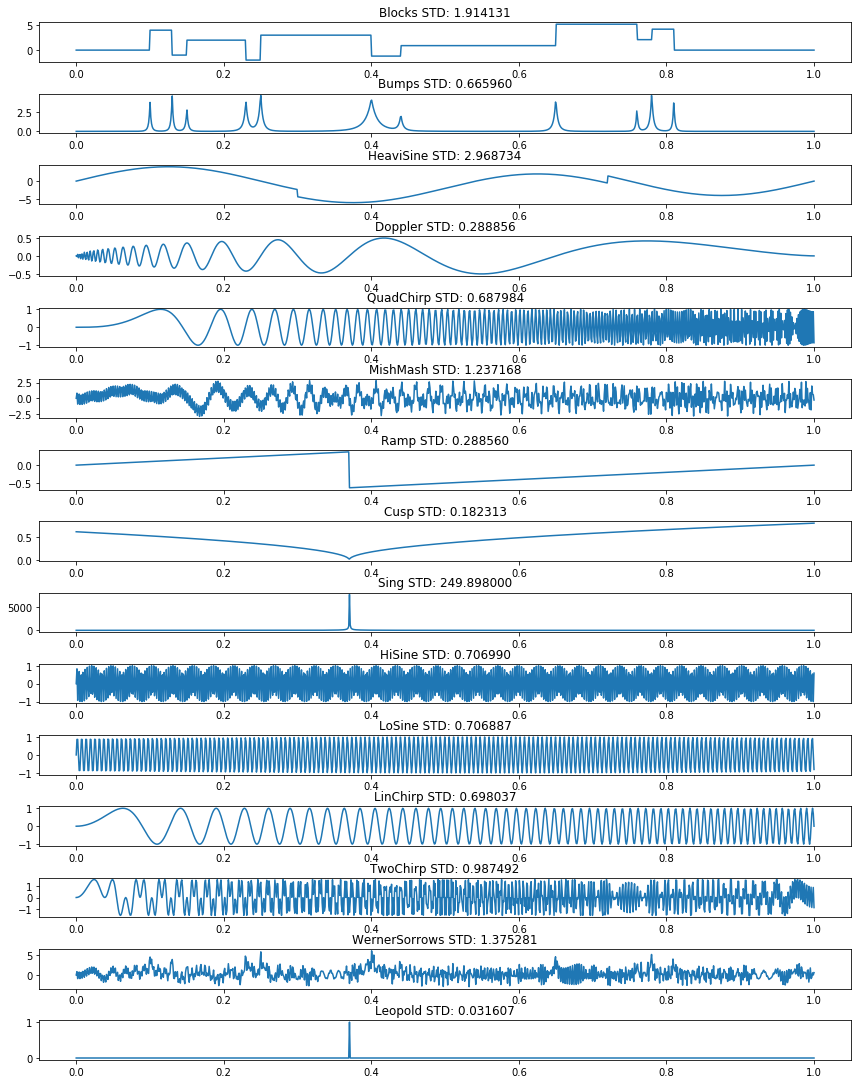

In [6]:
# Plot all the test functions. 
plots = 15
N = 1000   # Number of data points

fig, ax = plt.subplots(nrows=plots,ncols=1, figsize=(12,plots))
plt.tight_layout()

x = np.linspace(0.0, 1, N); 

for i in range( 1, plots+1 ):
    yy = makesig(MAKESIG_SIGNALS[i],t=x) 
    std = np.std(yy)
        
    plt.subplot(plots,1,i)
    plt.title(MAKESIG_SIGNALS[i] + " STD: %f" % std)
    plt.plot(x,yy) 

In [7]:
MAKESIG_SIGNALS

['AllSig',
 'Blocks',
 'Bumps',
 'HeaviSine',
 'Doppler',
 'QuadChirp',
 'MishMash',
 'Ramp',
 'Cusp',
 'Sing',
 'HiSine',
 'LoSine',
 'LinChirp',
 'TwoChirp',
 'WernerSorrows',
 'Leopold']

In [8]:
# Create the data (signal + noise) by selecting a signal type from the list MAKESIG_SIGNALS (above)
x_data = np.linspace(0.0, 1.0, HP.NUM_EXAMPLES) 
signal = makesig('Blocks',t=x_data) 
y_data = add_noise(signal, HP.SNR)

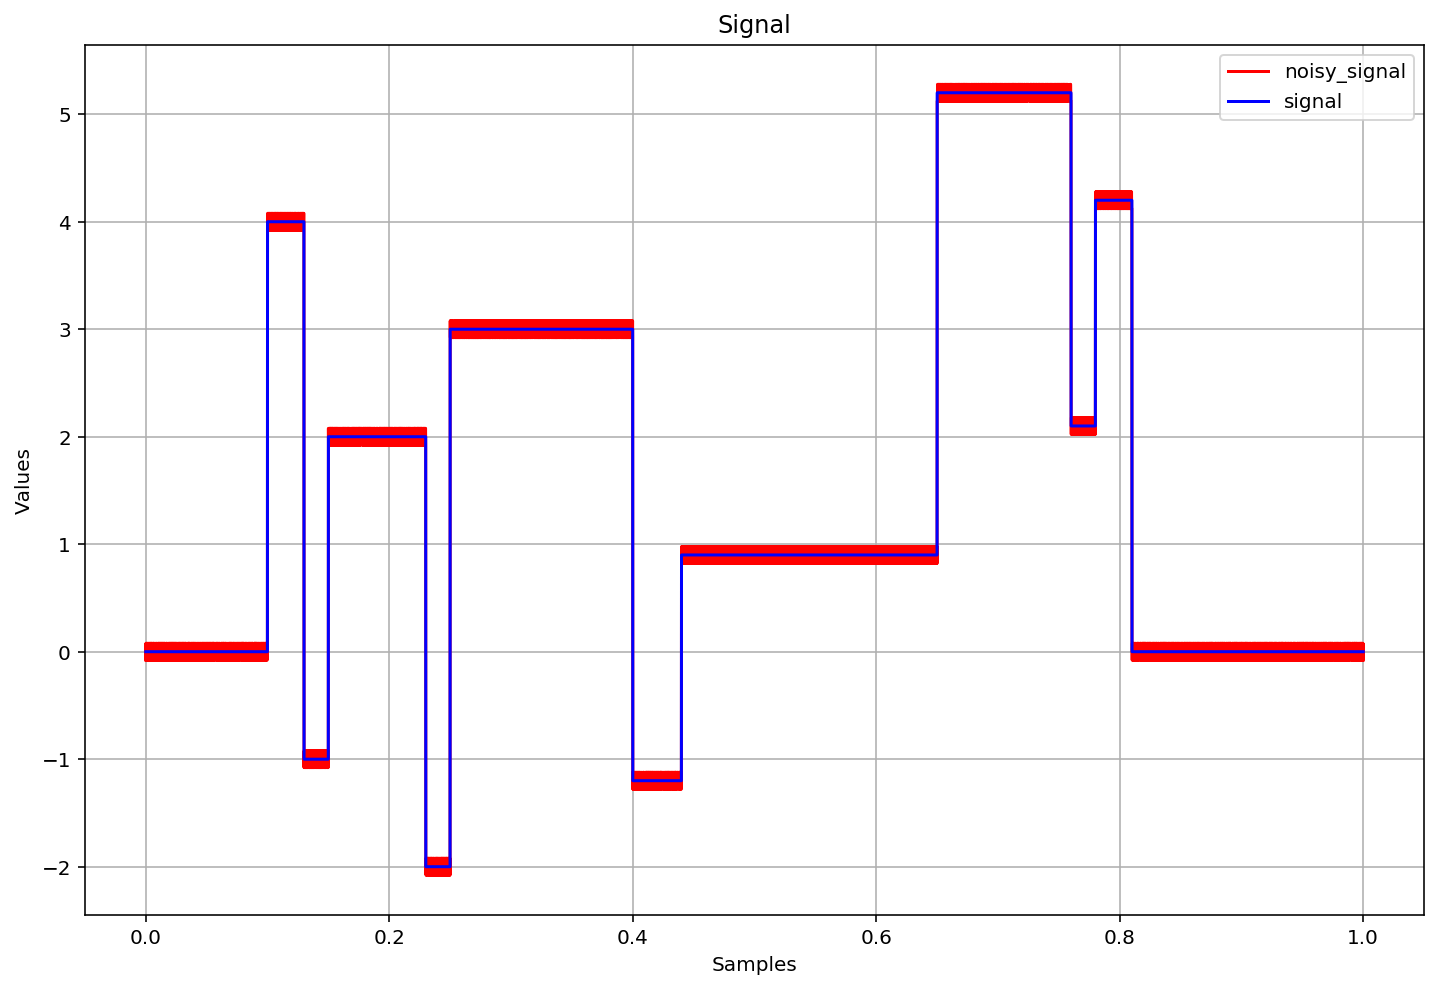

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(12,8))

plt.plot(x_data, y_data, color='r', label='noisy_signal')
plt.plot(x_data, signal, color='b', label='signal')
plt.title('Signal')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.grid()
plt.legend(loc='upper right');

In [10]:
# random shuffle data
idx = np.arange(HP.NUM_EXAMPLES)
np.random.shuffle(idx)
train_idx, validate_idx, test_idx = np.split(idx, [int(.6*len(idx)), int(.8*len(idx))]) #60%, 20%, 20% split 

x_data = np.float32(x_data).reshape(HP.NUM_EXAMPLES, 1)
y_data = np.float32(y_data).reshape(HP.NUM_EXAMPLES, 1)

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit_transform(y_data[train_idx]) # fit scaler on trainings data 
y_data = scaler.fit_transform(y_data)

train_x, train_y = x_data[train_idx], y_data[train_idx]
train_set = torch.utils.data.TensorDataset(torch.FloatTensor(train_x), torch.FloatTensor(train_y))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=HP.MINI_BATCH_SIZE, shuffle=True, 
                                           pin_memory=True, num_workers=0)

valid_x, valid_y  = x_data[validate_idx], y_data[validate_idx]
valid_set = torch.utils.data.TensorDataset(torch.FloatTensor(valid_x), torch.FloatTensor(valid_y))
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=HP.MINI_BATCH_SIZE, shuffle=True, 
                                           pin_memory=True, num_workers=0)

test_x, test_y  = x_data[test_idx], y_data[test_idx]
test_set = torch.utils.data.TensorDataset(torch.FloatTensor(test_x), torch.FloatTensor(test_x))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, pin_memory=False, num_workers=0)

train_x.shape, valid_x.shape, test_x.shape, train_y.shape, valid_y.shape, test_y.shape

((6000, 1), (2000, 1), (2000, 1), (6000, 1), (2000, 1), (2000, 1))

,x,y
count,6000.000000,6000.000000
mean,0.498980,-0.014388
std,0.289556,0.521854
min,0.000000,-1.000000
25%,0.246900,-0.413848
50%,0.501300,-0.169143
75%,0.749900,0.359469
max,0.999900,1.000000


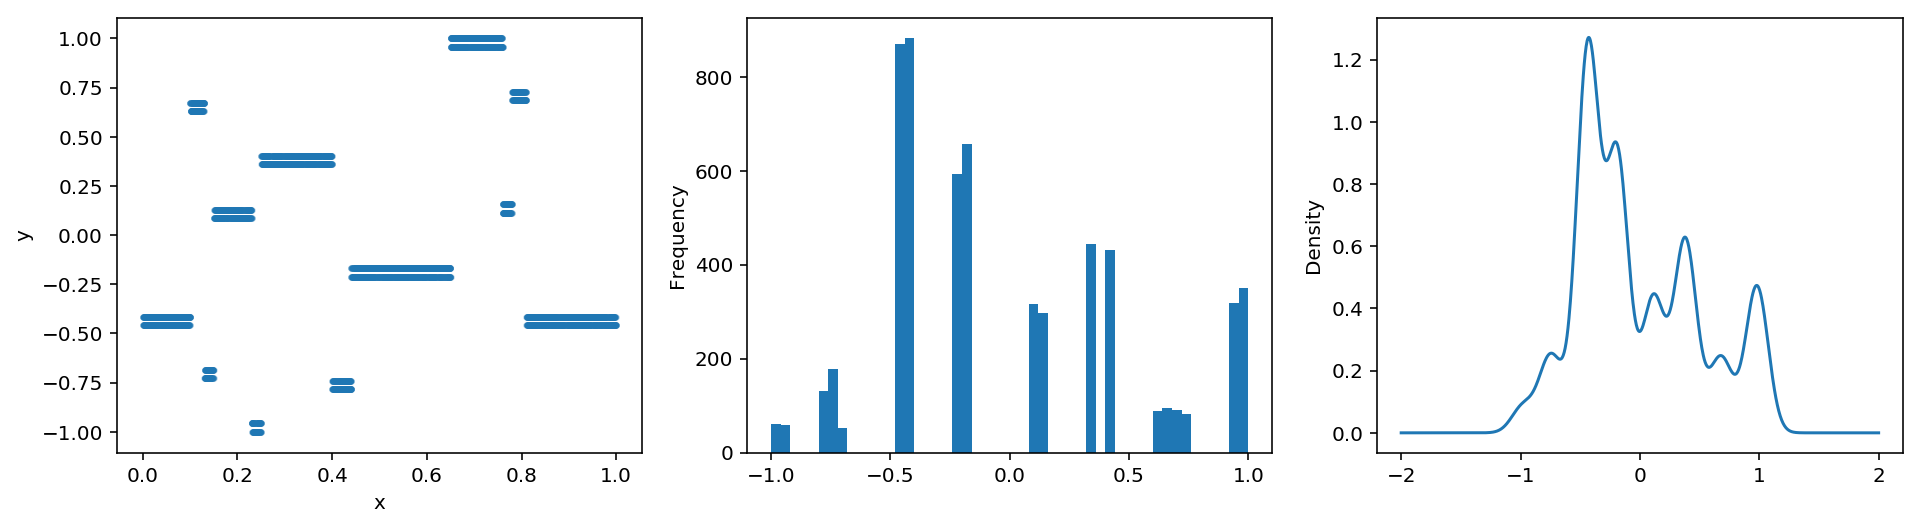

In [11]:
df = DataFrame({'x' : train_x.flatten(), 'y': train_y.flatten()})

fig, ax = plt.subplots(1,3,figsize=(16,4))

df.plot(kind='scatter', x='x', y='y', s=5.0, alpha=0.3, ax=ax[0])
df['y'].plot(kind='hist', bins=50, ax=ax[1])
df['y'].plot(kind='kde', ax=ax[2])

df.describe()

In [12]:
class MLP1(torch.nn.Module):
    
    def __init__(self, D_in, H, D_out):
        super(MLP1, self).__init__()
        
        self.input = nn.Sequential(
            nn.Linear(D_in, H, bias=False),
            nn.BatchNorm1d(H, affine=True),
            nn.ReLU(inplace=True)
        )
        
        self.residual1 = nn.Sequential(
            nn.Linear(H, H, bias=False),
            nn.BatchNorm1d(H, affine=True),
            nn.ReLU(inplace=True),
            nn.Linear(H, H, bias=False),
            nn.BatchNorm1d(H, affine=True)
        )
        self.relu1 = nn.ReLU(inplace=True)
        
        self.residual2 = nn.Sequential(
            nn.Linear(H, H, bias=False),
            nn.BatchNorm1d(H, affine=True),
            nn.ReLU(inplace=True),
            nn.Linear(H, H, bias=False),
            nn.BatchNorm1d(H, affine=True),
        )
        self.relu2 = nn.ReLU(inplace=True)
        
        self.regression = nn.Sequential(
            nn.Linear(H, D_out),
        )
                    
    def forward(self, x):
        h = self.input(x)
                        
        h = h + self.residual1(h)
        h = self.relu1(h)
        
        h = h + self.residual2(h)
        h = self.relu2(h)
                        
        y = self.regression(h)
        return y

In [13]:
model = MLP1(train_x.shape[1], HP.NUM_HIDDEN_NODES, train_y.shape[1])

glorot_weight_zero_bias(model)

if torch.cuda.is_available():
    model.cuda()

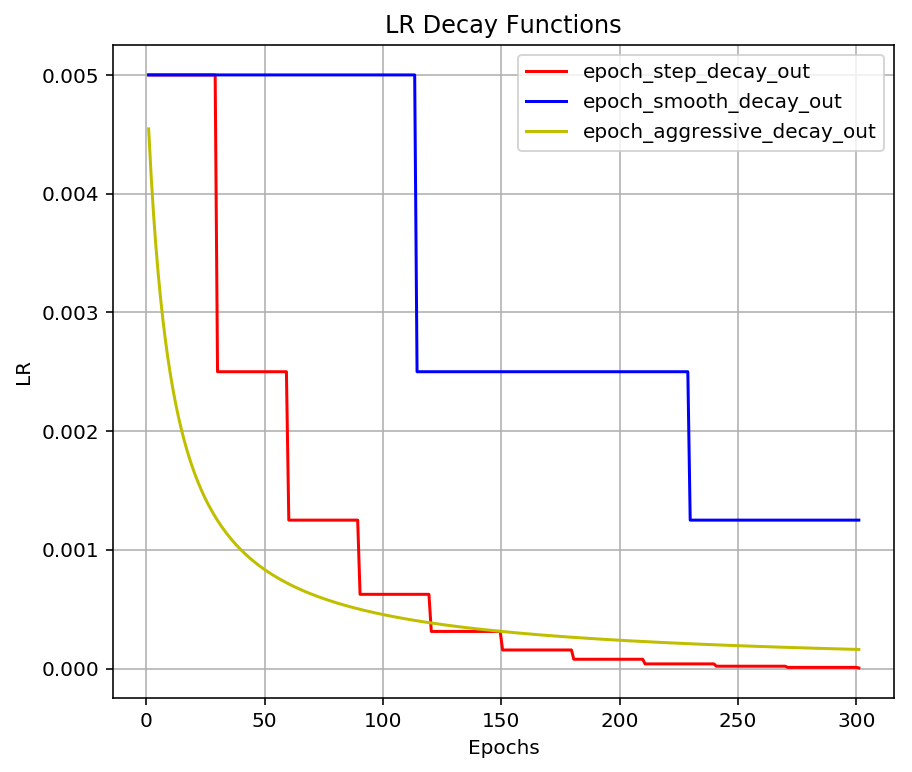

In [14]:
# Plot different learnings rate schedules
%matplotlib inline

epoch_step_decay = lambda epoch: HP.LEARNING_RATE * (0.5**(epoch // HP.LEARNING_RATE_DECAY))
epoch_smooth_decay = lambda epoch: HP.LEARNING_RATE * math.pow(0.5, math.floor((1 + epoch) / 115.0))
epoch_aggressive_decay = lambda epoch: HP.LEARNING_RATE * 1 / (1  + epoch * 1e-1/1 )

epts = np.linspace(1, HP.NUM_EPOCHS+1, HP.NUM_EPOCHS)

epoch_step_decay_out = np.vectorize(epoch_step_decay)(epts)
epoch_smooth_decay_out = np.vectorize(epoch_smooth_decay)(epts)
epoch_aggressive_decay_out = np.vectorize(epoch_aggressive_decay)(epts)

plt.figure(figsize=(7,6))
plt.plot(epts,epoch_step_decay_out, label='epoch_step_decay_out', color='r')
plt.plot(epts,epoch_smooth_decay_out, label='epoch_smooth_decay_out', color='b')
plt.plot(epts,epoch_aggressive_decay_out, label='epoch_aggressive_decay_out', color='y')
plt.title("LR Decay Functions")
plt.xlabel("Epochs");
plt.ylabel("LR");
plt.grid(True)
plt.legend(loc='upper right');

In [15]:
criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=HP.LEARNING_RATE, 
                            momentum=HP.NUM_MOMENTUM, 
                            weight_decay=HP.WEIGHT_DECAY, 
                            nesterov=True)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[epoch_step_decay])  # select the LR schedule
stopping = Stopping(model, patience= HP.NUM_PATIENCE)

<IPython.core.display.Javascript object>


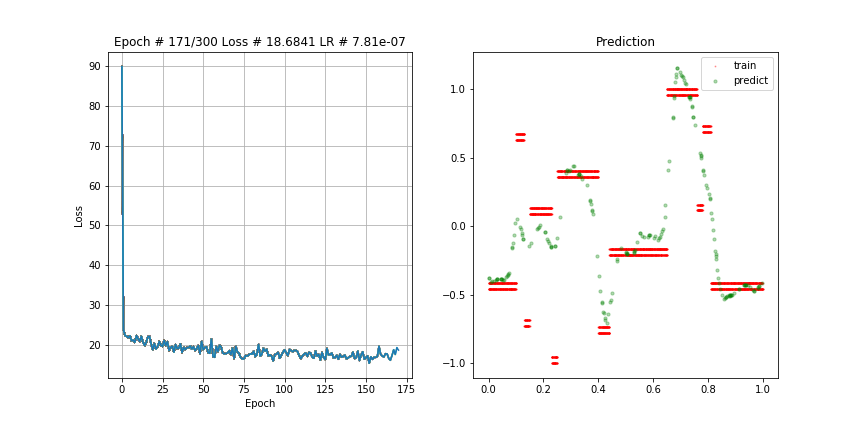

Epoch:  57%|█████▋    | 170/300 [01:25<01:05,  1.99it/s, loss=18.7, lr=7.81e-07]

Early stopping at epoch: 120, score 7.453148
Model training took 85.31 seconds.
=> saved checkpoint './chkp/MLP1-checkpoint.tar' (epoch 171)


{'GPU': True,
 'LEARNING_RATE': 0.005,
 'LEARNING_RATE_DECAY': 30,
 'MINI_BATCH_SIZE': 200,
 'NUM_EPOCHS': 300,
 'NUM_EXAMPLES': 10000,
 'NUM_HIDDEN_NODES': 50,
 'NUM_MOMENTUM': 0.9,
 'NUM_PATIENCE': 50,
 'SEED': 2018,
 'SIGNAL': 'Cusp',
 'SNR': 30,
 'TRAIN_SPLIT': 0.8,
 'WEIGHT_DECAY': 0.0005}

In [16]:
%matplotlib notebook

model.train()

pl = PlotLosses()

train_losses = []
valid_losses = []
valid_score = []
start = time.time()
epoch_iter = tqdm(range(1, HP.NUM_EPOCHS + 1))
for epoch in epoch_iter:
    epoch_iter.set_description('Epoch')

    with DelayedKeyboardInterrupt():

        scheduler.step()

        batch_idx, loss_avg = 0, 0
        for batch_idx, (data, target) in enumerate(train_loader):

            y_pred = model(to_var(data, async=True)) # predict y based on x
            loss = criterion(y_pred, to_var(target)) # compute loss

            optimizer.zero_grad() # clear gradients
            loss.backward() # compute gradients
            optimizer.step() # apply gradients

            loss_avg += loss.item()

        loss_avg /= batch_idx+1
        train_losses.append(loss_avg)
        
        batch_idx, loss_avg, score = 0, 0, 0
        for batch_idx, (data, target) in enumerate(valid_loader):

            y_pred = model(to_var(data, async=True)) # predict y based on x
            loss = criterion(y_pred, to_var(target)) # compute loss

            optimizer.zero_grad() # clear gradients
            loss.backward() # compute gradients
            optimizer.step() # apply gradients

            loss_avg += loss.item()
            score += r2_score(to_np(target), to_np(y_pred))

        loss_avg /= batch_idx+1
        valid_losses.append(loss_avg)
        valid_score.append(score)
        
        pl.plot_loss(train_losses, epoch, HP.NUM_EPOCHS, scheduler.get_lr()[0])
        pl.plot_prediction(train_x, train_y, data.numpy(), to_np(y_pred))

        stopping_flag = stopping.step(epoch, valid_losses[-1], valid_score[-1])
        
        epoch_iter.set_postfix(loss=train_losses[-1], lr=scheduler.get_lr()[0])
        
        if stopping_flag:
            print("Early stopping at epoch: %d, score %f" % (stopping.best_score_epoch, stopping.best_score))
            break
            
print("Model training took %.2f seconds." % (time.time() - start))

save_checkpoint({
    'model' : type(model).__name__,
    'hyperparameters' : HP,
    'epoch': epoch,
    'loss' : loss.item(),
    'state_dict': stopping.best_score_state,
    'optimizer' : optimizer.state_dict()
},
    filename='./chkp/MLP1-checkpoint.tar')

display(HP)

pl.close()

In [17]:
# Load the 
%matplotlib inline

net = MLP1(train_x.shape[1], HP.NUM_HIDDEN_NODES, train_y.shape[1])

checkpoint = load_checkpoint(net, filename='./chkp/MLP1-checkpoint.tar')
display("Name: " + checkpoint['model'],
        "Epoch: %d" % checkpoint['epoch'],
        "Loss: %.4f" % checkpoint['loss'],
        checkpoint['hyperparameters'])

net.eval()
if torch.cuda.is_available():
    net.cuda()
    
y_pred = []
for data, target in test_loader:
    
    output = net(to_var(data))

    y_pred.append(to_np(output)[0])

y_pred = np.array(y_pred)

=> loaded checkpoint './chkp/MLP1-checkpoint.tar' (epoch 171)


'Name: MLP1'

'Epoch: 171'

'Loss: 13.3071'

{'GPU': True,
 'LEARNING_RATE': 0.005,
 'LEARNING_RATE_DECAY': 30,
 'MINI_BATCH_SIZE': 200,
 'NUM_EPOCHS': 300,
 'NUM_EXAMPLES': 10000,
 'NUM_HIDDEN_NODES': 50,
 'NUM_MOMENTUM': 0.9,
 'NUM_PATIENCE': 50,
 'SEED': 2018,
 'SIGNAL': 'Cusp',
 'SNR': 30,
 'TRAIN_SPLIT': 0.8,
 'WEIGHT_DECAY': 0.0005}

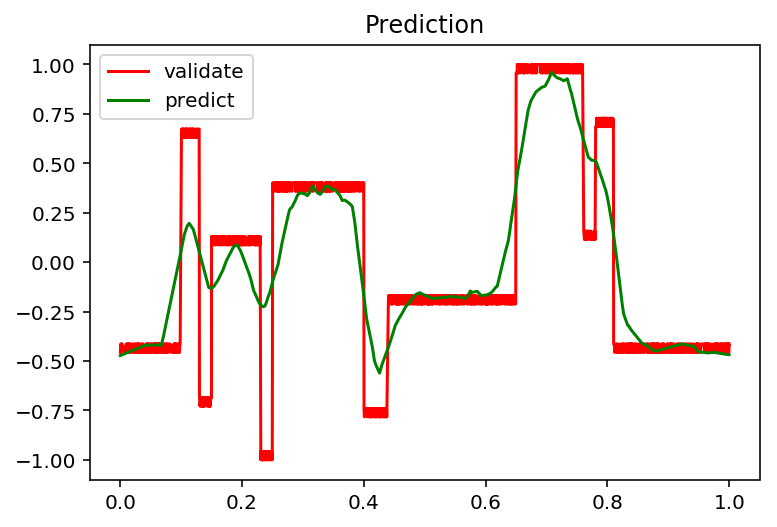

In [18]:
plot_prediction(test_x, test_y, test_x, y_pred, "Prediction", "validate", "predict")

In [24]:
stat_summary(test_y.flatten(), y_pred.flatten(), test_y.shape[0], sum([np.prod(p.size()) for p in net.parameters()]))


Date:  Fri, 31 Aug 2018
Time:  14:45:59
Parameters:                10601           Cases:  2000
Models stats
Mean Squared Error         0.065249         
Mean Absolute Error        0.065249         
Root Mean Squared Error    0.255439         
R-squared                  0.756401         


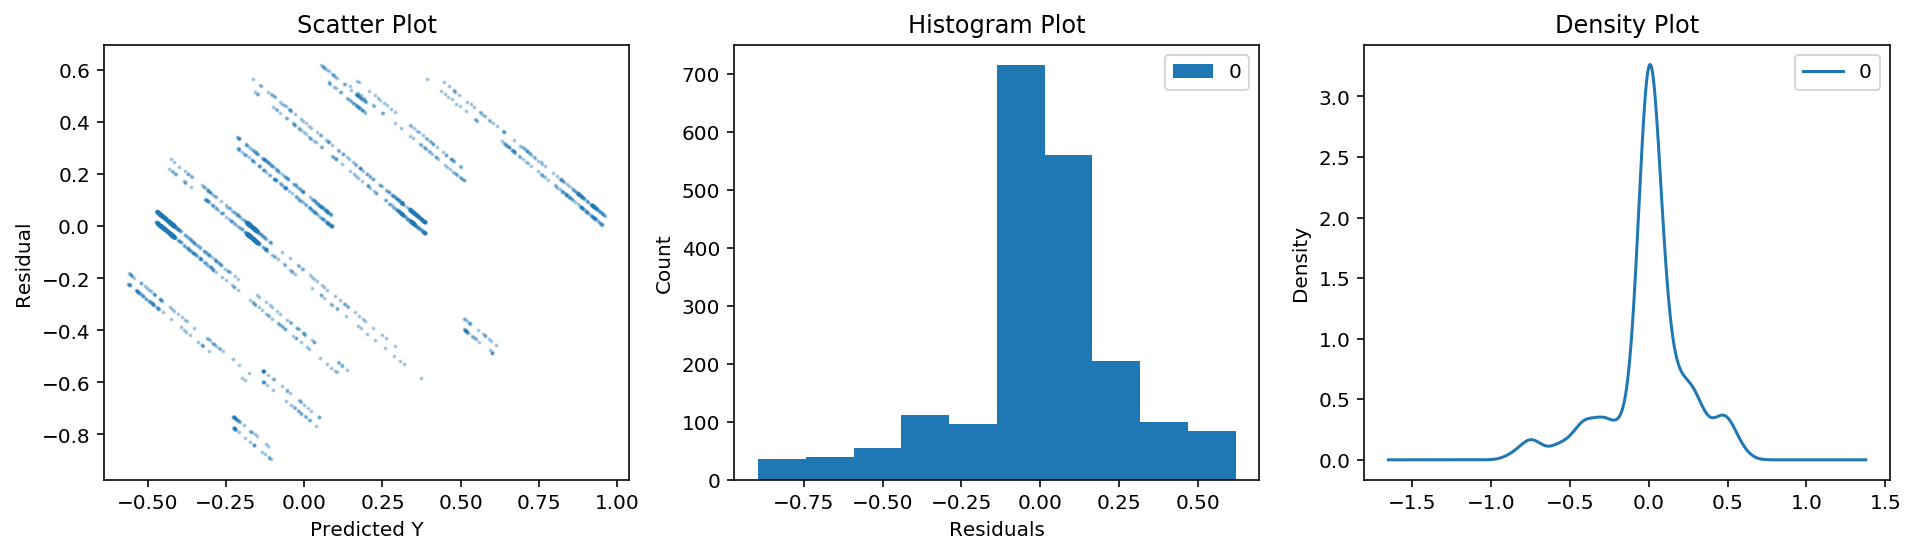

In [25]:
residual_plots(test_y.flatten(), y_pred.flatten())

In [21]:
print_summary(model)

Summary for model: MLP1
_________________________________________________________________
Layer (type)                 Shape                     Param #   
input.0 (Linear)             ((50, 1),)                50        
_________________________________________________________________
input.1 (BatchNorm1d)        ((50,), (50,))            100       
_________________________________________________________________
input.2 (ReLU)               ()                        0         
_________________________________________________________________
residual1.0 (Linear)         ((50, 50),)               2500      
_________________________________________________________________
residual1.1 (BatchNorm1d)    ((50,), (50,))            100       
_________________________________________________________________
residual1.2 (ReLU)           ()                        0         
_________________________________________________________________
residual1.3 (Linear)         ((50, 50),)            

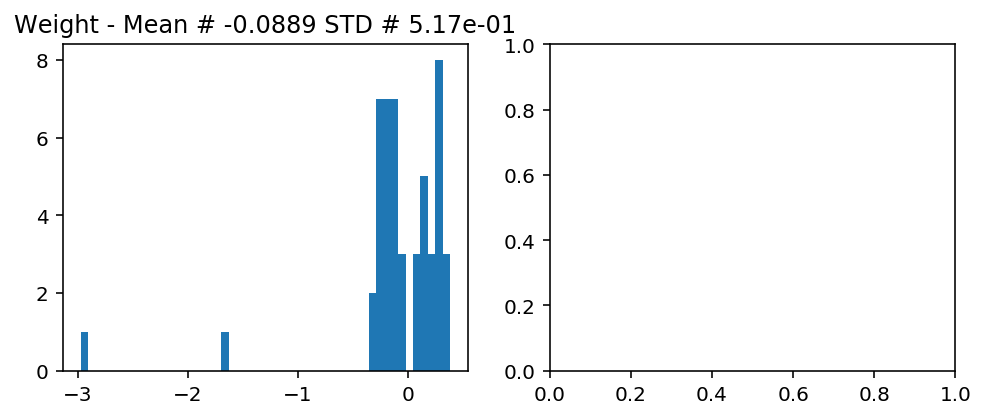

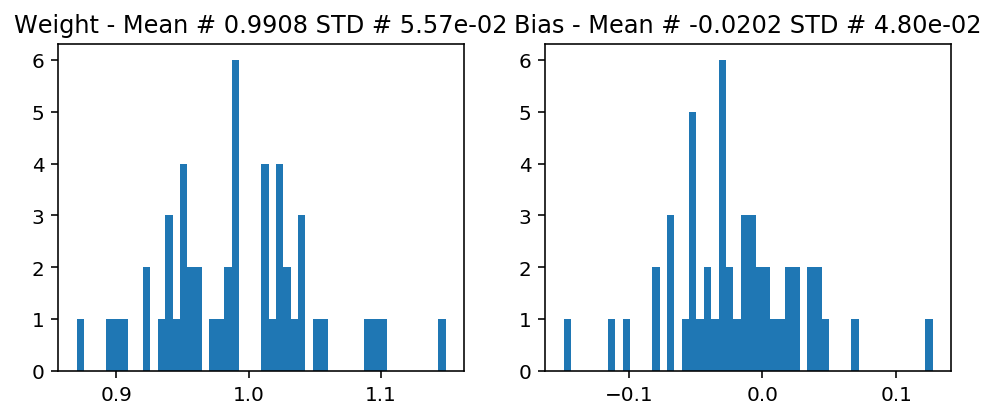

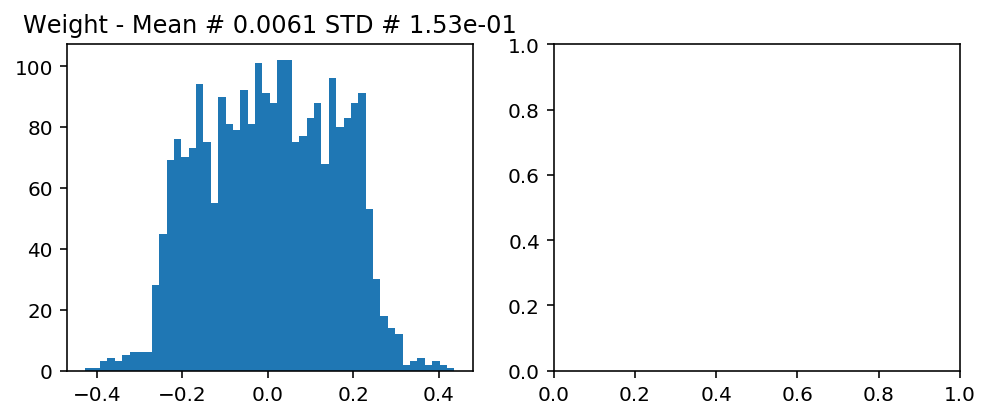

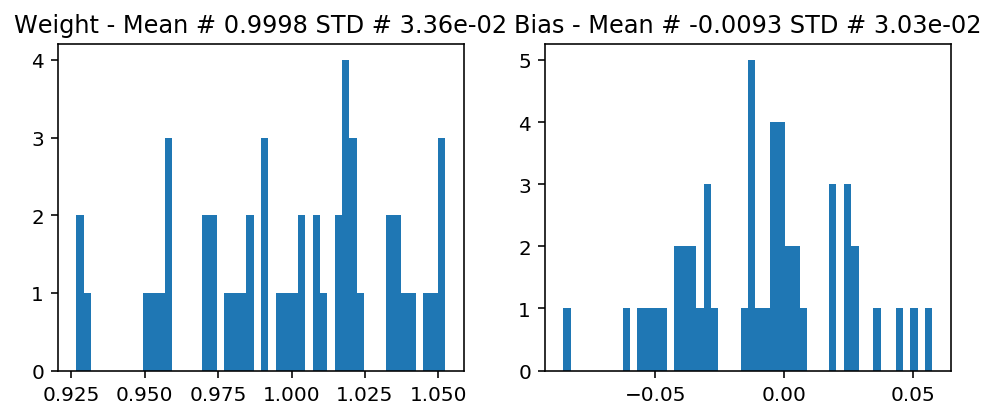

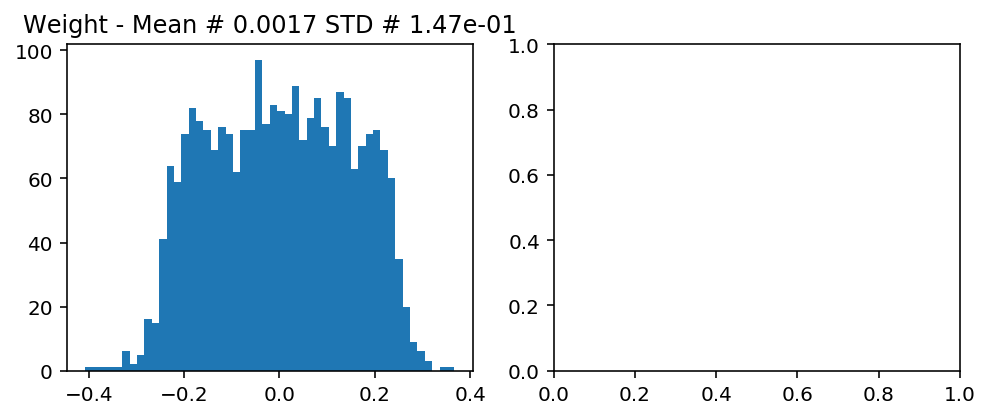

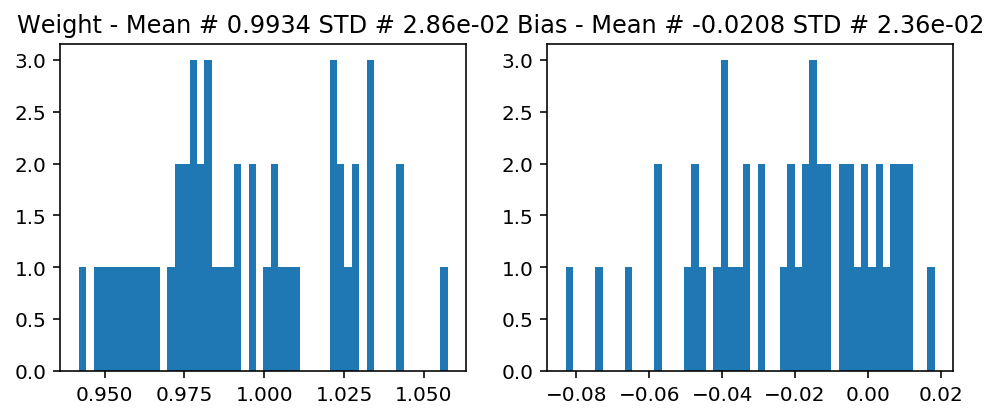

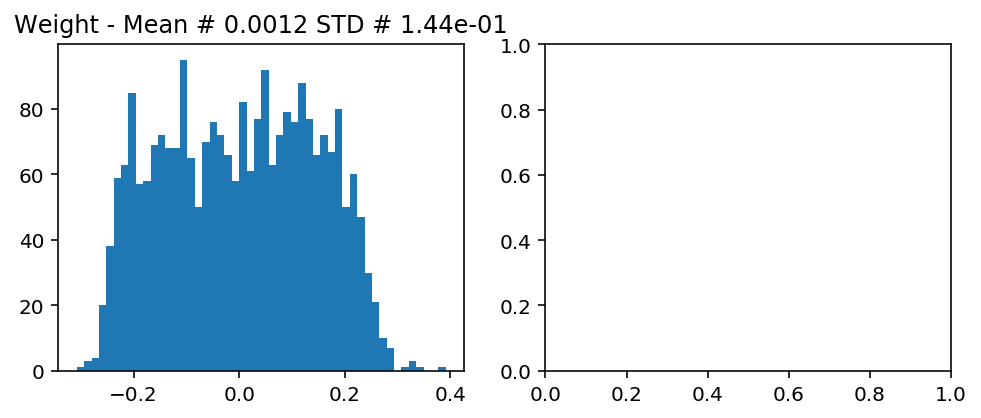

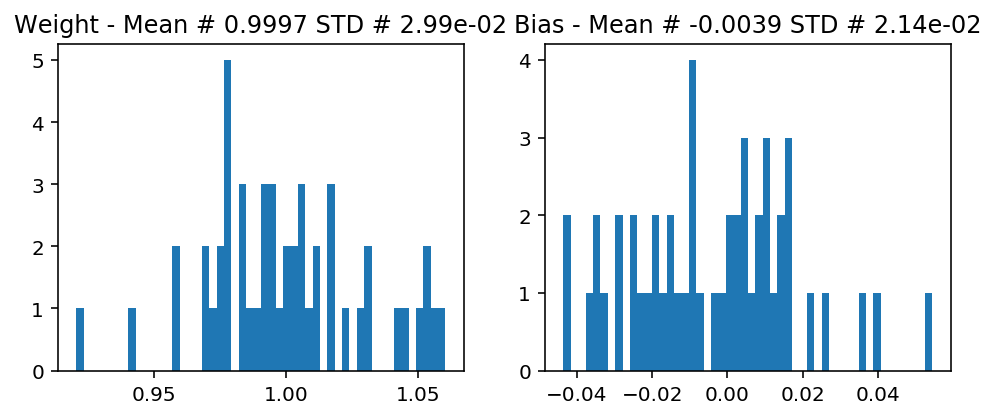

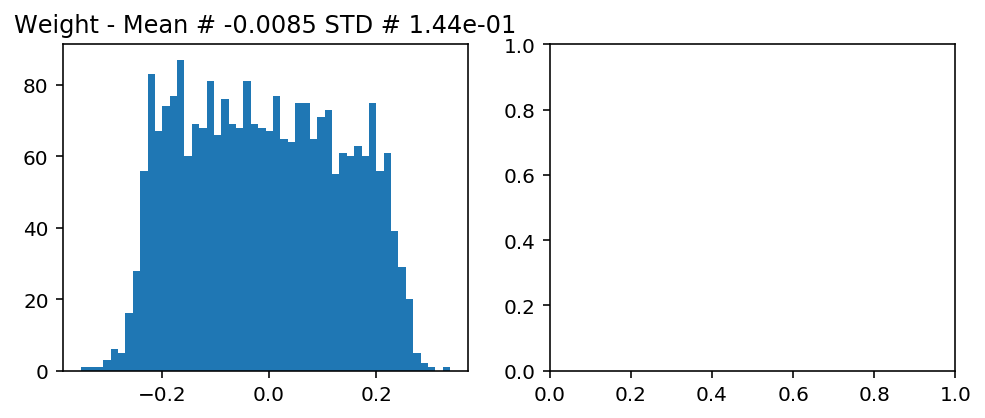

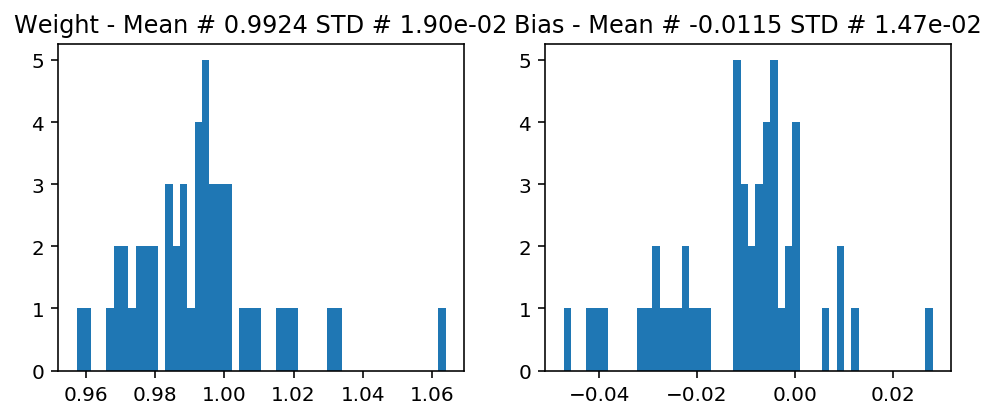

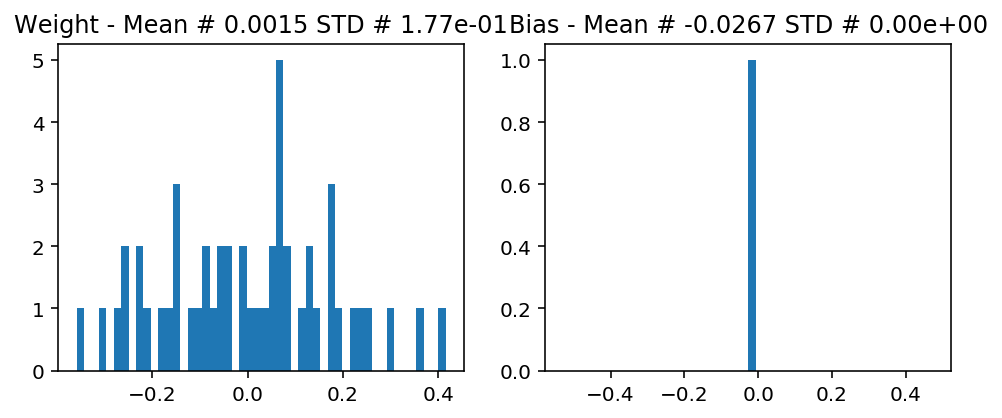

In [22]:
layer_stats(model)

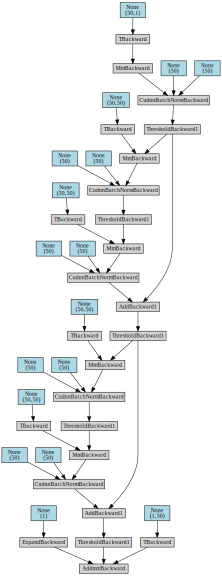

In [23]:
make_dot(output, net.state_dict())